# This Notebook Works best in google colab

In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import nibabel as  nib
from scipy import ndimage
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Download url of normal ct scans
# url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
# filename = os.path.join(os.getcwd(), "CT-0.zip")
# tf.keras.utils.get_file(filename, url)

# #Download url of abnormal ct scans
# url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
# filename = os.path.join(os.getcwd(), "CT-23.zip")
# tf.keras.utils.get_file(filename, url)

# if not os.path.exists("./MosMedData"):
#     os.makedirs("MosMedData")

# with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
#     z_fp.extractall("./MosMedData/")
    
# with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
#     z_fp.extractall("./MosMedData/")

In [4]:
import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
    """Read and load volume"""
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


def normalize(volume):
    """Normalize the volume"""
    min = -1000
    max = 400
    volume[volume < min] = min
    volume[volume > max] = max
    volume = (volume - min) / (max - min)
    volume = volume.astype("float32")
    return volume


def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Rotate
    img = ndimage.rotate(img, 90, reshape=False)
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    return img


def process_scan(path):
    """Read and resize volume"""
    # Read scan
    volume = read_nifti_file(path)
    # Normalize
    volume = normalize(volume)
    # Resize width, height and depth
    volume = resize_volume(volume)
    return volume

In [23]:
# Folder "CT-0" consist of CT scans having normal lung tissue,
# no CT-signs of viral pneumonia.
normal_scan_paths = [
    os.path.join(os.getcwd(),"gdrive/MyDrive/MosMedData/CT-0", x)
    for x in os.listdir("gdrive/MyDrive/MosMedData/CT-0")
]
# Folder "CT-23" consist of CT scans having several ground-glass opacifications,
# involvement of lung parenchyma.
abnormal_scan_paths = [
    os.path.join(os.getcwd(),"gdrive/MyDrive/MosMedData/CT-23", x)
    for x in os.listdir("gdrive/MyDrive/MosMedData/CT-23")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths)))

CT scans with normal lung tissue: 100
CT scans with abnormal lung tissue: 100


In [24]:
# Read and process the scans.
# Each scan is resized across height, width, and depth and rescaled.
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

# For the CT scans having presence of viral pneumonia
# assign 1, for the normal ones assign 0.
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)

Number of samples in train and validation are 140 and 60.


In [26]:
print("train.shape and validation.shape are {0} and {1}".format(x_train.shape, x_val.shape))

train.shape and validation.shape are (140, 128, 128, 64) and (60, 128, 128, 64)


In [27]:
import random

from scipy import ndimage


@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float32)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

In [28]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Augment the on the fly during training.
train_dataset = (
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

(128, 128, 64, 1)
(2,)


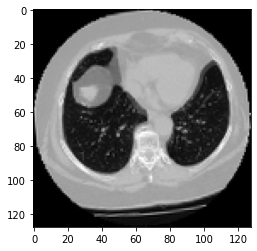

In [29]:
for d in train_dataset.take(1):
    image, label = list(d)[0],list(d)[1]
    image = image[0]
    print(image.shape)
    print(label.shape)
    plt.imshow(np.squeeze(image[:, :, 24]), cmap="gray")

In [53]:
def plot_slices(num_rows, num_columns, width, height, data, fig_width = 12.0):
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [ slc[0].shape[0] for slc in data]
    widths = [ slc.shape[1] for slc in data[0]]
#     print(heights)
#     print(widths)
    fig_height = fig_width * sum(heights)/ sum(widths)
    fig, ax = plt.subplots(rows_data, columns_data, figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},)
    for i in range(rows_data):
        for j in range(columns_data):
            ax[i,j].imshow(data[i][j], cmap = 'gray')
            ax[i,j].axis('off')
    plt.subplots_adjust(wspace = 0, hspace = 0, left = 0, right = 1, bottom = 0, top = 1)
    plt.show()

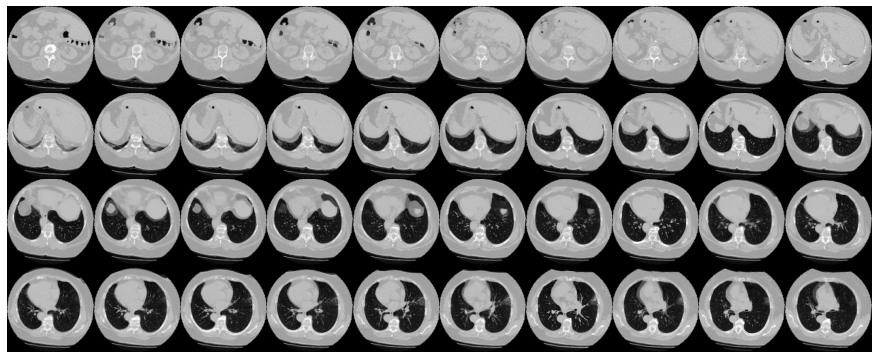

In [54]:
plot_slices(4, 10, 128, 128, image[:,:,:40])

In [32]:
# for d in train_dataset.take(1):
#     for i in list(d)[0]:
#         print(i[0].shape[0])
#     break

In [33]:
# for d in train_dataset.take(1):
#     for i in d[0]:
#         print(i.shape[1])
#     break

In [35]:
def get_model(width=128, height=128, depth=64):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((width, height, depth, 1))

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=256, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    outputs = tf.keras.layers.Dense(units=1, activation="sigmoid")(x)

    # Define the model.
    model = tf.keras.Model(inputs, outputs, name="3dcnn")
    return model


# Build model.
model = get_model(width=128, height=128, depth=64)
model.summary()

Model: "3dcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 64, 1)] 0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 126, 126, 62, 64)  1792      
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 63, 63, 31, 64)    0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 63, 63, 31, 64)    256       
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 61, 61, 29, 64)    110656    
_________________________________________________________________
max_pooling3d_5 (MaxPooling3 (None, 30, 30, 14, 64)    0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 30, 30, 14, 64)    256   

In [42]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    metrics=[tf.keras.metrics.AUC(name = 'auc'),"acc"],
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("3d_image_classification.h5", save_best_only = True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor = 'val_acc', patience = 10, mode = 'max', verbose = 1,
                           restore_best_weights = True)

In [43]:
epochs = 100
r = model.fit(train_dataset, validation_data = validation_dataset,
              epochs = epochs,
              shuffle = True,
              verbose = True,
             callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/100
70/70 [==============================] - 41s 570ms/step - loss: 0.6407 - auc: 0.7145 - acc: 0.6714 - val_loss: 0.5131 - val_auc: 0.8533 - val_acc: 0.7333
Epoch 2/100
70/70 [==============================] - 38s 546ms/step - loss: 0.5897 - auc: 0.7635 - acc: 0.6857 - val_loss: 0.6996 - val_auc: 0.8500 - val_acc: 0.6500
Epoch 3/100
70/70 [==============================] - 38s 546ms/step - loss: 0.5989 - auc: 0.7289 - acc: 0.6429 - val_loss: 0.4880 - val_auc: 0.8583 - val_acc: 0.7667
Epoch 4/100
70/70 [==============================] - 39s 551ms/step - loss: 0.5827 - auc: 0.7542 - acc: 0.6857 - val_loss: 1.6178 - val_auc: 0.8006 - val_acc: 0.5000
Epoch 5/100
70/70 [==============================] - 38s 539ms/step - loss: 0.5838 - auc: 0.7615 - acc: 0.7000 - val_loss: 1.0779 - val_auc: 0.8472 - val_acc: 0.5167
Epoch 6/100
70/70 [==============================] - 38s 546ms/step - loss: 0.5609 - auc: 0.7802 - acc: 0.7214 - val_loss: 0.9897 - val_auc: 0.8222 - val_acc: 0.5833
Epoc

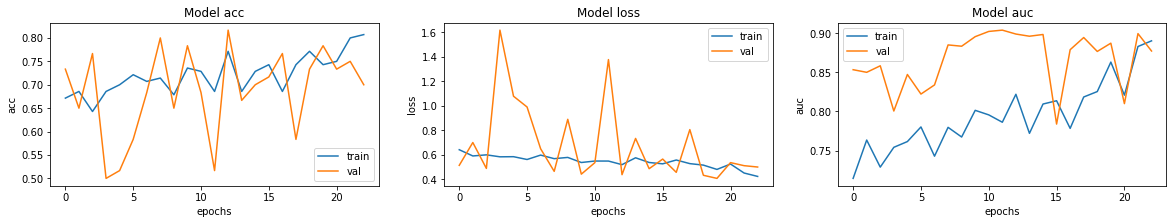

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss", "auc"]):
    ax[i].plot(r.history[metric])
    ax[i].plot(r.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

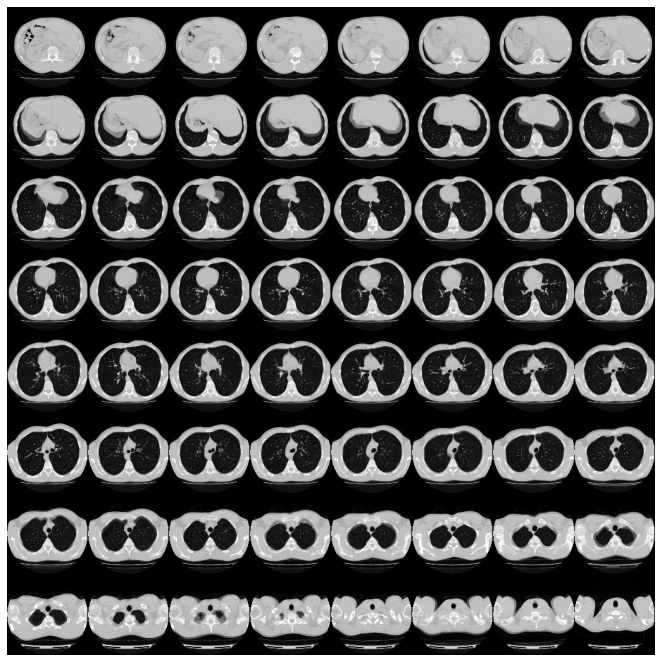

This model is 89.79 percent confident that CT scan is normal
This model is 10.21 percent confident that CT scan is abnormal


In [67]:
# Load best weights.
model.load_weights("3d_image_classification.h5")
idx = np.random.randint(0,60)
prediction = model.predict(np.expand_dims(x_val[idx], axis=0))[0]
scores = [1 - prediction[0], prediction[0]]
# plot  x_val[0,:,:,12], cmap = 'gray')
plot_slices(8, 8, 128, 128, x_val[idx].reshape(128,128,64,1), fig_width = 9)
class_names = ["normal", "abnormal"]
for score, name in zip(scores, class_names):
    print(
        "This model is %.2f percent confident that CT scan is %s"
        % ((100 * score), name)
    )